In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy
import cv2

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "images/PlantVillage/",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

(32, 256, 256, 3)
tf.Tensor([0 0 2 0 0 1 0 1 0 0 1 1 1 0 1 0 0 1 0 1 1 0 0 0 1 0 0 0 0 2 1 0], shape=(32,), dtype=int32)
[0 0 2 0 0 1 0 1 0 0 1 1 1 0 1 0 0 1 0 1 1 0 0 0 1 0 0 0 0 2 1 0]


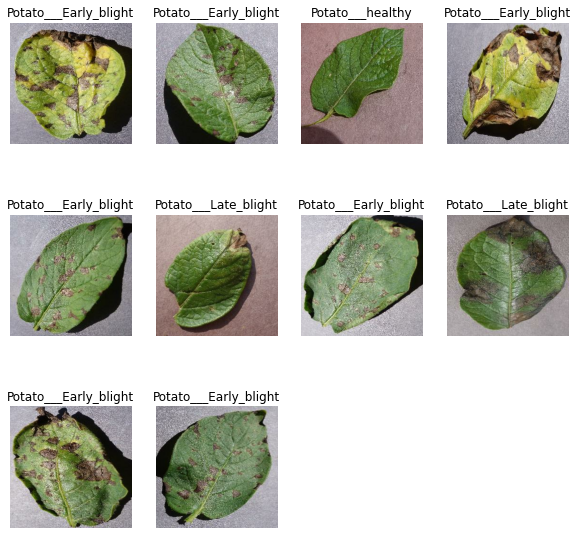

In [5]:

for image_batch, label_batch in dataset.take(1):
    plt.figure(figsize=(10,10))
    for i in range(10):
        plt.subplot(3,4, i + 1)
        plt.axis("off")
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
    print(image_batch.shape)
    print(label_batch)
    print(label_batch.numpy())

### 20% testing = 10% validation = 10% testing

In [9]:
def split_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle_size=10000):
    
    if shuffle_size != -1: 
        ds = ds.shuffle(shuffle_size, seed=12)
    ds_len = len(ds)
    print(f"ds_len {ds_len}")
    train_size = int(ds_len * train_split)
    print(f"train_size {train_size}")
    train_ds = ds.take(train_size)
    print(f"train_ds {len(train_ds)}")
    
    test_ds = ds.skip(train_size)
    print(f"test_ds original {len(test_ds)}")
    # divide by 2 to get 10% of validaiton and 10% for testing
    half = int(len(test_ds) / 2)
    val_ds = test_ds.take(half)
    test_ds = test_ds.skip(half)
    print(f"val_ds {len(val_ds)}")
    print(f"test_ds {len(test_ds)}")
    
    return (train_ds, val_ds, test_ds)

(train_ds, val_ds, test_ds) = split_dataset(dataset)

ds_len 68
train_size 54
train_ds 54
test_ds original 14
val_ds 7
test_ds 7


### Store in cache as it improves the pipeline because we don't have to access the disc and just store the image in memory

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds  = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds  = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
image_preprocessing = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),  # we resize so that when we later supply an image, it gets automatically resized to 256,256
    layers.Rescaling(1./255),
])

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [26]:
n_classes = 3
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3)
model = tf.keras.Sequential([
    image_preprocessing,
    data_augmentation,
    layers.Conv2D(32, (3,3), padding="same", activation="relu", input_shape=input_shape ),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    layers.MaxPool2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="softmax")
])

In [27]:
model.build(input_shape=input_shape)

In [28]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_18 (Conv2D)          (32, 256, 256, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (32, 128, 128, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (32, 128, 128, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (32, 64, 64, 64)         0         
 g2D)                                                 

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds, epochs = 50, batch_size = BATCH_SIZE, verbose=1, validation_data=val_ds)